In [1]:
import numpy as np
import matplotlib.pylab as plt

import tidy3d as td
import tidy3d.web as web

from tidy3d.plugins.dispersion import DispersionFitter
# from tidy3d.plugins.dispersion import FastDispersionFitter, AdvancedFastFitterParam

num_Al2O3 122230
num_SiO2 44


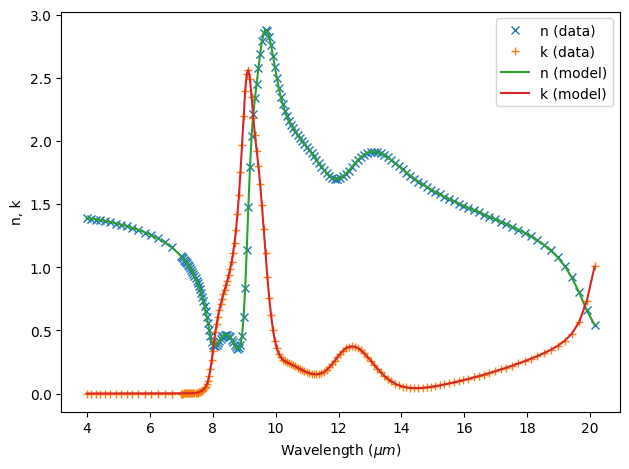

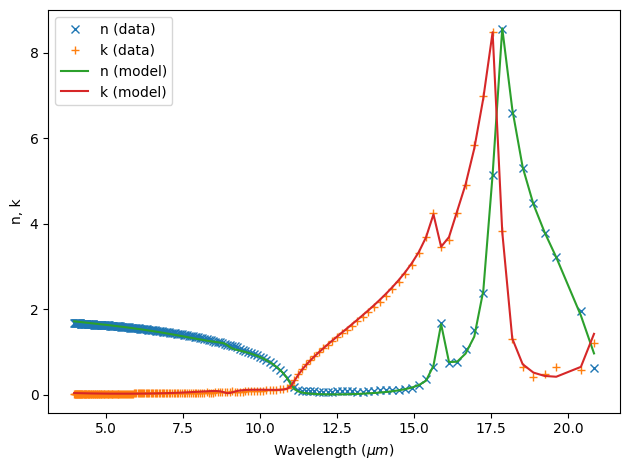

freq_start: 14989622900000.0
freq_end: 74948114500000.0
lda_start: 4
sim_size: (20, 20, 180)


In [2]:
# Define Paramters
# radius and location of the sphere
radius_Al2O3 = 0.25
radius_SiO2 = 4 # exp is 6um
box_size_xy = 20
box_size_z = 100

vol_Al2O3 = 4/3 * np.pi * np.power(radius_Al2O3,3)
vol_SiO2 = 4/3 * np.pi * np.power(radius_SiO2,3)
vol_box = box_size_xy * box_size_xy * box_size_z
num_Al2O3 = int(np.floor(0.2 * vol_box / vol_Al2O3))   # 20% of volumn is Al2O3
num_SiO2 = int(np.floor(0.3 * vol_box / vol_SiO2))   # 30% of volumn is SiO2
print('num_Al2O3',num_Al2O3)
print('num_SiO2',num_SiO2)

center = [0, 0, 0]

# Version 2.4.0rc1

# permittivity of the Al2O3 sphere 
mat_SiO2 = "data/mat_SiO2.csv"
mat_Al2O3 = "data/mat_Al2O3.csv"

# # note that additional keyword arguments to load_nk_file get passed to np.loadtxt
# advanced_param = AdvancedFastFitterParam(weights=(1,1))
# fitter = FastDispersionFitter.from_file(mat_SiO2, skiprows=1, delimiter=",")
# medium_SiO2, rms_error = fitter.fit(max_num_poles=9, advanced_param=advanced_param, tolerance_rms=2e-2)
# fitter.plot(medium_SiO2)
# plt.show()

# fitter = FastDispersionFitter.from_file(mat_Al2O3, skiprows=1, delimiter=",")
# medium_Al2O3, rms_error = fitter.fit(max_num_poles=9, advanced_param=advanced_param, tolerance_rms=2e-2)
# fitter.plot(medium_Al2O3)
# plt.show()

# fname = "data/medium_SiO2.json"
# medium_SiO2.to_file(fname)
# fname = "data/medium_Al2O3.json"
# medium_Al2O3.to_file(fname)

# Version 2.3.3
medium_SiO2 = td.PoleResidue.from_file("data/medium_SiO2.json")
medium_Al2O3 = td.PoleResidue.from_file("data/medium_Al2O3.json")

fitter = DispersionFitter.from_file(mat_SiO2, skiprows=1, delimiter=",")
fitter.plot(medium_SiO2)
plt.show()

fitter = DispersionFitter.from_file(mat_Al2O3, skiprows=1, delimiter=",")
fitter.plot(medium_Al2O3)
plt.show()

# free space central wavelength
wl_start = 4  # wavelength
wl_end = 20  # wavelength
freq_start = td.C_0 / wl_end
freq_end = td.C_0 / wl_start
print('freq_start:',freq_start)
print('freq_end:',freq_end)

freqs = np.linspace(freq_start, freq_end, 100)  # freqeucny range of the simulation
freq0 = (freq_start + freq_end)/2  # central frequency
freqw = freq_end - freq_start  # width of the frequency range

lda_start = wl_start
print('lda_start:',lda_start)

# distance between the surface of the sphere and the start of the PML layers along each cartesian direction
buffer_PML = 2 * wl_end
buffer_source = 1 * wl_end

# resolution control
min_steps_per_wvl = 20

# set the domain size in x, y, and z
domain_size_xy = box_size_xy 
domain_size_z = buffer_PML + box_size_z + buffer_PML

# construct simulation size array
sim_size = (domain_size_xy, domain_size_xy, domain_size_z)
print('sim_size:',sim_size)

In [3]:
# Create random structures
SiO2_geometry = []
Al2O3_geometry = []
geometry = []
for i in range(num_SiO2):
    position_xy = (box_size_xy - 2*radius_SiO2) * (np.random.rand(2) - 0.5) 
    position_z = (box_size_z - 2*radius_SiO2) * (np.random.rand(1) - 0.5) 
    position = [position_xy[0],position_xy[1],position_z]
    sphere = td.Sphere(center=position, radius=radius_SiO2)
    SiO2_geometry.append(sphere)
    
geometry.append(td.Structure(geometry=td.GeometryGroup(geometries=SiO2_geometry), medium=medium_SiO2))
   
for i in range(num_Al2O3):
    position_xy = (box_size_xy - 2*radius_Al2O3) * (np.random.rand(2) - 0.5) 
    position_z = (box_size_z - 2*radius_Al2O3) * (np.random.rand(1) - 0.5)
    position = [position_xy[0],position_xy[1],position_z]
    sphere = td.Sphere(center=position, radius=radius_Al2O3)
    Al2O3_geometry.append(sphere)

geometry.append(td.Structure(geometry=td.GeometryGroup(geometries=Al2O3_geometry), medium=medium_Al2O3))
geometry = tuple(geometry)
print('Geometry Finish')


Geometry Finish


In [4]:
# add a plane wave source
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=0.5 * freqw),
    size=(td.inf, td.inf, 0),
    center=(0, 0, box_size_z/2 + buffer_source),
    direction="-",
    pol_angle=0,
)

# add a flux monitor to detect transmission
monitor_t = td.FluxMonitor(
    center=[0, 0, -box_size_z/2 - (buffer_source+buffer_PML)/2], size=[td.inf, td.inf, 0], freqs=freqs, name="T"
)

# add a flux monitor to detect reflection
monitor_r = td.FluxMonitor(
    center=[0, 0, box_size_z/2 + (buffer_source+buffer_PML)/2], size=[td.inf, td.inf, 0], freqs=freqs, name="R"
)

# add a field monitor to see the field profile at the absorption peak frequency
monitor_field = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, box_size_z], freqs=[freq0], name="field"
)

print('Source and Monitor setup Finish')

Source and Monitor setup Finish


In [5]:
run_time = 2e-11  # simulation run time

# set up simulation
sim = td.Simulation(
    size=sim_size,
#     grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lda_start), # Non uniform grip
    grid_spec=td.GridSpec.uniform(dl =lda_start/10),
    structures=geometry,
    sources=[plane_wave],
    monitors=[monitor_t, monitor_r, monitor_field],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
    ), 
#     boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),  # PML boundary
)  # symmetry can be used to greatly reduce the computational cost

print('Simulation setup Finish')

Simulation setup Finish


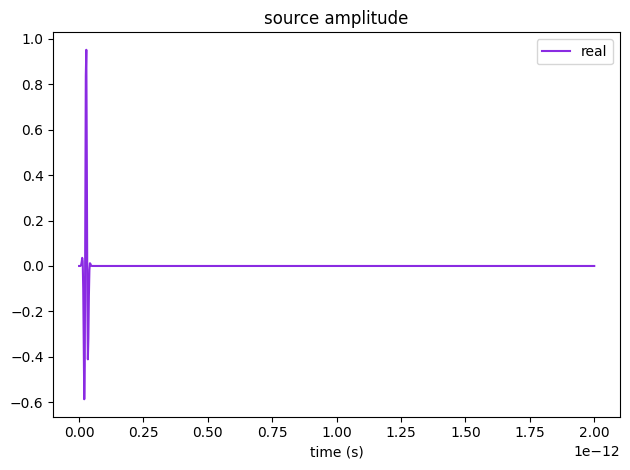

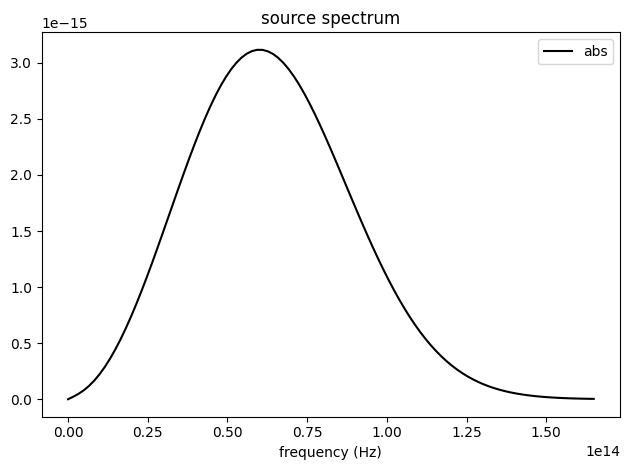

In [6]:
# Visualize source
plane_wave.source_time.plot(np.linspace(0, run_time/10, 1001))
plt.show()

plane_wave.source_time.plot_spectrum(
    times=np.linspace(0, run_time/10, 2000), val="abs"
)
plt.show()

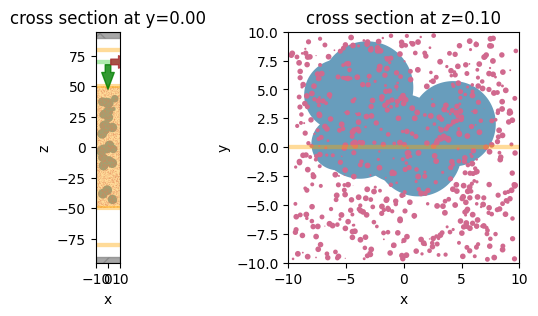

Visualize Source Finish


In [7]:
cfig, ax = plt.subplots(1, 2, figsize=(7, 3))
sim.plot(y=0, ax=ax[0])
sim.plot(z=0.1, freq=freq0, ax=ax[1])
plt.show()

print('Visualize Source Finish')

In [8]:
task_id = web.upload(sim, task_name="Simulation")
# print("Max flex unit cost: ", web.estimate_cost(task_id))

[16:14:15] Created task 'Simulation' with task_id 'fdve-61c2a0c2-aff8-4339-b68d-e213ac55c8d2v1'.      ]8;id=874226;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=634200;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py#189\189]8;;\

           View task using web UI at                                                                  ]8;id=668013;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=31122;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py#191\191]8;;\
           ]8;id=153087;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c2a0c2-aff8-4339-b68d-e213ac55c8d2v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=228086;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c2a0c2-aff8-4339-b68d-e213ac55c8d2v1\taskId]8;;\]8;id=153087;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c2a0c2-aff8-4339-b68d-e213ac55c8d2v1\=]8;;\]8;id=38953;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c2a0c2-aff8-4339-b68d-e213ac55c8d2v1\fdve]8;;\]8;id=153087;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c2a0c2-aff8-4339-b68d-e213ac55c8d2v1\-61c2a0c2-aff8-4339-b68d-e213ac55c8d]8;;\              
           ]8;id=153087;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c2a0c2-aff8-4339-b68d-e213ac55c8d2v1\2v1']8;;\.                                                                                                   

C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\rich\live.py:229: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [9]:
web.start(task_id)
web.monitor(task_id, verbose=True)

import time
time.sleep(4)
print("Billed flex unit cost: ", web.real_cost(task_id))

sim_data = web.load(task_id, path="data/cooling.hdf5")

# Show the output of the log file
print(sim_data.log)

[16:14:36] status = queued                                                                            ]8;id=842679;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=177993;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py#363\363]8;;\

[16:14:57] status = preprocess                                                                        ]8;id=368374;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=330210;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py#357\357]8;;\

[16:15:28] Maximum FlexCredit cost: 0.072. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=642162;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=844252;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=886212;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=735296;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py#379\379]8;;\

[16:15:29] running solver                                                                             ]8;id=89729;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=283868;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py#389\389]8;;\

           To cancel the simulation, use 'web.delete(task_id)' or delete the task in the web UI.      ]8;id=364008;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=161003;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\
           Terminating the Python script will not stop the job running on the cloud.                               

[16:15:59] early shutoff detected, exiting.                                                           ]8;id=813296;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=438659;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py#407\407]8;;\

           status = postprocess                                                                       ]8;id=791528;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=855627;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py#424\424]8;;\

[16:16:19] status = success                                                                           ]8;id=523327;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=108987;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py#431\431]8;;\

Billed flex unit cost:  0.04035189300695991


[16:16:34] loading SimulationData from data/cooling.hdf5                                              ]8;id=792084;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=633824;file://C:\Users\54377\anaconda3\envs\Tidy3d\lib\site-packages\tidy3d\web\webapi.py#609\609]8;;\

Simulation domain Nx, Ny, Nz: [50, 50, 474]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 1.1900e+06.
Using subpixel averaging: True
Number of time steps: 2.6227e+04
Automatic shutoff factor: 1.00e-05
Time step (s): 7.6263e-16


Compute source modes time (s):     25.9119
Compute monitor modes time (s):    1.2723
Rest of setup time (s):            10.1497

Running solver for 26227 time steps...
- Time step     35 / time 2.67e-14s (  0 % done), field decay: 1.00e+00
- Time step   1049 / time 8.00e-13s (  4 % done), field decay: 7.81e-02
- Time step   2098 / time 1.60e-12s (  8 % done), field decay: 2.58e-03
- Time step   3147 / time 2.40e-12s ( 12 % done), field decay: 3.64e-04
- Time step   4196 / time 3.20e-12s ( 16 % done), field decay: 1.26e-04
- Time step   5245 / time 4.00e-12s ( 20 % done), field decay: 6.84e-05
- Time step   6294 / time 4.80e-12s ( 24 % done), field decay: 3.84e-05
- Time step   7343 / time 5.60e-12s ( 28 % done), field decay: 2.96e-05
- Time

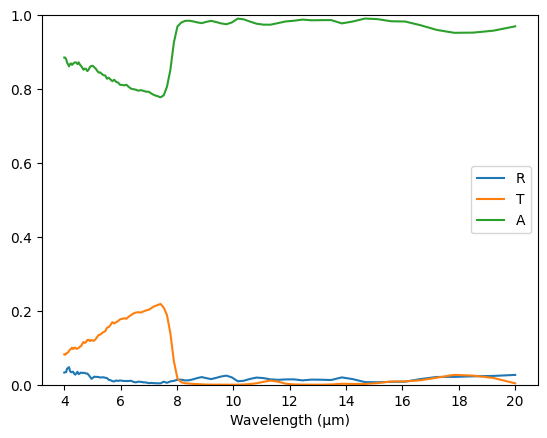

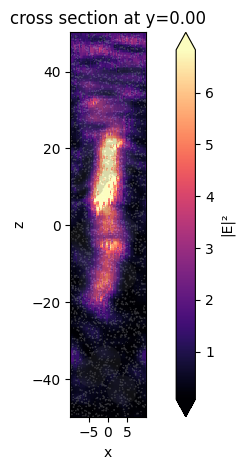

In [10]:
# Result Visualization
R = sim_data["R"].flux
T = -sim_data["T"].flux
A = 1 - R - T
plt.plot(td.C_0 /freqs, R, td.C_0 /freqs, T, td.C_0 /freqs, A)
np.savetxt('data/Abs_4-20um.txt', (np.transpose((td.C_0 /freqs, A))))

plt.xlabel("Wavelength (μm)")
plt.ylim(0, 1)
plt.legend(("R", "T", "A"))
plt.show()

sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2")
plt.show()